# Dense Neural Network and embedding for NLP

In this exercise, I explore the use of Dense Neural Network applied to NLP.
The goal is to provide an example of NLP classification in the form of sentiment
analysis using tensorflow. The general workflow is the same as in the previous exercise but with the addition of embedding. We will look into:

- preprocessing
- vectorization
- embedding
- feature extraction and classification using DNN

## Preprocessing

Text often contains unecessary information or words we may want to modify or remove to help the task and training.  Common preprocessing steps include removing punctuation, lower casing or stop words. Stop words are words that are not useful in the process of classification. The words 'the' or 'is' are very common in English are not usually useful in the process of classification. Care should be taken when using stop words. For instance, if the task is related to sentiment analysis, we should keep 'not' which is also a very common English.
The preprocess steps vary and can be  defined before the text vectorization or as part of the vectorization process. When carried out as part of the vectorization, we can pass a function or set specific parameters from the vectorizer (depending on the ML framework used).

## Vectorization

Before using any ML method, we must first convert the text into numerical values. This is the process of tokenization or vectorization. We can choose different levels for the tokens of the text: characters, words or sentences. In this exercise, we will use word tokenization and will explore sentence tokenization later.

The output of this step is typically a tensor/matrix with documents as rows and tokens as columns. There are multiple variations of the matrix (count, frequency, tfidf). In the case of one hot encoding vectorization, the matrix shows the presence of a token for a document. In the case of a frequency count vectorization matrix, it shows the frequency of each words in a document. In most cases, the matrix/tensor is sparse and is processed to reduce its dimension.

## Embedding

Embedding provides a way to represent text using continuous vector values. It can represent tokens relationship or semantic relations in more efficient way. Vectorization can produce very large sparse and embedding provides more useful ways to represent words in reduced size space. Example of typical embedding include Word2vec and GLOVE. These embeddings were created on very large text dataset and often called pre-trained embedding space. In this exercise, we create our own embedding layer in the deep learning model using the text corpus we have.

The text vectorization and embedding steps are sometimes called encoding.

## Dense Neural Network: features and classification

Embedding layers will feed into intermediary layers that will create features of relevance to the classification. This usually called the feature extractor (backbone) of the DL neural network. The top or head of the network contains the classifier: the neural network corresponding to a binary or multiple category classification.

## Dataset

In this exercise, we use the Twitter US airline sentiment dataset. It is a public dataset published used in the Kaggle competition published in 2015. It contains about 16k reviews classified into three sentiment categories: negative, neutral and positive.

Useful links:

- twitter sentiment airlines data:

https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment


# Set up environment and load libraries

- load libraries
- install packages and tools
- authenticate to google drive and gcp account

In [1]:
!pip uninstall tensorflow -y
!pip install  tensorflow==2.13 #specific version needed for BERT

Found existing installation: tensorflow 2.13.0
Uninstalling tensorflow-2.13.0:
  Successfully uninstalled tensorflow-2.13.0
  Using cached tensorflow-2.13.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (524.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.13.0 which is incompatible.


In [2]:
!pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56441 sha256=13f0e8a697e3aaec1afb842da4ef854bd65c8a82163269849838ed711afc033f
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [3]:
###### Library used in this script
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os, glob

#ML imports
import sklearn
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


#Keras import
from tensorflow import keras
#from keras.models import Model
import tensorflow as tf

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, Concatenate, Activation, MaxPool2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model


#from keras.utils import np_utils
import np_utils
sns.set_style('darkgrid')
pd.set_option('display.max_colwidth', None)

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter

import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('display.max_columns', 50)

#Please download the below also. This will resolve your issue:

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

#nltk.download('omw-1.4'*)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
#GCP account authentification
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [6]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Functions
In the next part of the script, we declare all the functions used in the sripts.  It is good practice to place functions at the beginning of a script or in an external source file. Here are the 13 functions used:

* **create_dir_and_check_existence**:  create and output directory given a path. The output directory will be the working directory throughout the analysis.


In [7]:
def create_dir_and_check_existence(path):

    #Create a new directory
    try:
        os.makedirs(path)
    except:
        print ("directory already exists")

from matplotlib import pyplot

In [8]:
def clean_text(data):

    import re

    #1. Removing URLS
    data = re.sub('http\S+', '', data).strip()
    data = re.sub('www\S+', '', data).strip()

    #2. Removing Tags
    data = re.sub('#\S+', '', data).strip()

    #3. Removing Mentions
    data = re.sub('@\S+', '', data).strip()

    #4. Removing upper brackets to keep negative auxiliary verbs in text
    data = data.replace("'", "")

    #5. Tokenize
    text_tokens = word_tokenize(data.lower())

    #6. Remove Puncs and number
    tokens_without_punc = [w for w in text_tokens if w.isalpha()]

    #7. Removing Stopwords
    stop_words = stopwords.words('english')
    for i in ["not", "no"]:
            stop_words.remove(i)
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]

    #8. lemma
    text_cleaned = [WordNetLemmatizer().lemmatize(t) for t in tokens_without_sw]


    #joining
    return " ".join(text_cleaned)

In [9]:
#pulled from tensorflow tutorial and more
#https://stackoverflow.com/questions/70854665/tensorflow-textvectorization-convert-the-predicted-text-back-to-a-human-readabl

def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<\b>' ,' ')
  return tf.strings.regex_replace(stripped_html,'[%s#@]' % re.escape(string.punctuation),'')

def normalize(text):
  remove_regex = f'[{re.escape(string.punctuation)}]'
  space_regex = '...'
  result = tf.strings.lower(text)
  result = tf.strings.regex_replace(result, remove_regex, '')
  result = tf.strings.regex_replace(result, space_regex, ' ')
  return result

In [10]:
def generate_accuracy(model,y_test,x_test,class_names=None):

  """
  Function to predict and generate accuracy metrics (precision and recall) for each model given input x and y test.

  Extended description of function.

  Parameters:
  model: keras model
  y_test: Input target for test
  y_train: target train labels used in classification
  class_names: labels for the class predicted

  Returns:
  report_df: pandas data frame with accuracy metrics

  """

  # we can store the array in a data.frame and get the max
  y_score = model.predict(x_test)
  y_score.shape
  y_pred_test_df = pd.DataFrame(y_score)
  y_pred_test_df['y_pred_test'] = y_pred_test_df.idxmax(axis = 1) #one to go across the column for each row
  y_pred_test_df


  y_pred_test = y_pred_test_df['y_pred_test']
  report_dict=classification_report(y_test,
                                      y_pred_test,
                                      target_names=class_names,
                                      output_dict=True)
  report_df = pd.DataFrame(report_dict)
  #confusion_matrix_val = confusion_matrix(y_test,y_pred_test)  #not in use here
  model_name = model._name
  #display(report_df)
  report_df = (report_df.drop(columns=['macro avg','weighted avg'])
                        .drop(labels=['f1-score','support'])
                        .assign(model_name= lambda x: model_name)
                        .assign(num_param= lambda x: model.count_params())
                        .reset_index()
                        .rename(columns={'index':'metric'})
              )

  return report_df

# Parameters and Arguments

It is good practice to set all parameters and input arguments at the beginning of the script. This allows for better control and can make modifications of the scripts for other applications easier. Some arguments relate to path directories, input files and general parameters for use in the analyses (e.g. proportion of hold out).


In [11]:
############################################################################
#####  Parameters and argument set up ###########

#ARG 1
in_dir = '/content/gdrive/MyDrive/Colab Notebooks/deep-learning-nlp-intro/DNN_and_embedding_nlp/data'
out_dir = '/content/gdrive/MyDrive/Colab Notebooks/deep-learning-nlp-intro/DNN_and_embedding_nlp/'

#in_filename = 'Tweets.csv'
in_filename = 'training.1600000.processed.noemoticon.csv'
in_filename_cleaned = 'df_tweets_sentiment140_cleaned.csv'
out_suffix = 'DNN_embedding_nlp_2024-03-27'
test_proportion = 0.2
random_seed= 42
create_out_dir = True
run_preprocess = False

#ARG 7
## Input data
data_dir = '/content/drive/MyDrive/Colab Notebooks/deep-learning-nlp-intro/DNN_embedding_nlp/data/'
#ARG 8
run_model = True #if True, model is trained, note this may take several hours.

#ARG 9
# Use pre-trained model if run_model is False
model_path = None
#model_path ='/content/drive/MyDrive/Colab Notebooks/deep-learning-nlp-intro/DNN_embedding_nlp/'
#ARG 10
epoch_val = 100
#ARG 11
run_preprocess = False


In [12]:
################# START SCRIPT ###############################

######### PART 0: Set up the output dir ################

#set up the working directory
#Create output directory

if create_out_dir==True:
    out_dir_new = "output_data_"+out_suffix
    out_dir = os.path.join(out_dir,"outputs",out_dir_new)
    create_dir_and_check_existence(out_dir)
    os.chdir(out_dir)        #set working directory
else:
    os.chdir(out_dir) #use working dir defined earlier


In [13]:
print(out_dir)

/content/gdrive/MyDrive/Colab Notebooks/deep-learning-nlp-intro/DNN_and_embedding_nlp/outputs/output_data_DNN_embedding_nlp_2024-03-27


In [14]:
!pwd

/content/gdrive/MyDrive/Colab Notebooks/deep-learning-nlp-intro/DNN_and_embedding_nlp/outputs/output_data_DNN_embedding_nlp_2024-03-27


#0.Workflow/pipeline

We describe here the modeling pipelin we set up for this exercise:
1. **Load and explore data**
- Obtain data from the website or link provided
- Quick exploration
2. **Intro to Textvectorization and Embedding: tensorflow**
- defining layers
- hyper parameters
3. **Train test split**
- create test test split
4. **Build and train models**
- build DNN model
- build LSTM model
- build CNN model
- train models
5. **Accuracy Assessement and evaluation of models**
- prediction on test data
- confusion matrix
- precisions recal metrics for all models
6. **Conclusions**
- summarize lab/exercise and discuss results

# 1.Load and explore data

We used the airlines review sentiment data tweets from Kaggle. There are 14,640 tweets labeled with three sentiment categories:

- negative
- neutral
- positive

There were 15 columns including airline name and confidence in the label. Here are the most relevant columns for the modeling:

- text: column: contains the tweet text
- airline_sentiment: contains the labeled sentiment categories.

In [15]:
# Check for GPU
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


In [16]:
import tensorflow as tf
print(tf.__version__) #should use higher tensorflow!!!

2.13.0


In [17]:
#https://www.kaggle.com/datasets/kazanova/sentiment140/code
#df = pd.read_csv(os.path.join(in_dir,in_filename),encoding='latin-1')
df = pd.read_csv(os.path.join(in_dir,in_filename),header=None,encoding='latin-1')

#target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
#ids: The id of the tweet ( 2087)
#date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
#flag: The query (lyx). If there is no query, then this value is NO_QUERY.
#user: the user that tweeted (robotickilldozr)
#text: the text of the tweet (Lyx is cool)

column_names = ['target','ids','date','flag','user','text']
df.columns = column_names
print(df.shape)
print(df.columns)
df

(1600000, 6)
Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')


,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best feeling ever
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interviews! â« http://blip.fm/~8bmta
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me for details
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur


 #(0 = negative, 4 = positive)

In [18]:
print(df['target'].value_counts())
print(df['target'].value_counts(normalize=True))


0    800000
4    800000
Name: target, dtype: int64
0    0.5
4    0.5
Name: target, dtype: float64


The dataset is clearly balanced.

#2. **Intro to Textvectorization and Embedding: tensorflow**

We will first explore the textvectorization and embedding layers provided in tensorflow keras using a mock up dataset (see corpus below).

We'll take a look at:

- defining layers: instantiate layers for exploration and fit

- hyper parameters: parameters that can be set when using the layers.

We'll use a mock-up/fake dataset that consists in 4 sentences with a variety of length with some unusual characters (# and @).

In [19]:
corpus = [
'Food service was slow and the food was bad and late.',
'@airlineZ The flight was very delayed.',
'#airlineZ Food was cold and very late.',
'I asked for water and coffee but it never came'
]

## 2.1 Textvectorization

Let's use the default parameter values first to explore the vectorization layer. Here is a short description of the main parameters:

- max_tokens: maximum number of token to consider for the modeling. It will take most frequent tokens up to the maximum number.
- standardize: preprocessing for the input text, this can be a specific option ('lower', 'lower_and_strip_punctuation') or custom function.


Intersesting links:
- https://jonathan-hui.medium.com/tensorflow-keras-preprocessing-layers-dataset-performance-considera-e9fc11de7bc7: good overview of textvectorization layer

- https://discuss.tensorflow.org/t/nlp-textvectorization-tokenizer/12505/3
- https://towardsdatascience.com/you-should-try-the-new-tensorflows-textvectorization-layer-a80b3c6b00ee5


In [20]:
#import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

vectorizer = TextVectorization(max_tokens=None,
                              standardize="lower_and_strip_punctuation",
                              split="whitespace",
                              ngrams=None,
                              output_mode="int",
                              output_sequence_length=None,
                              pad_to_max_tokens=False,
                              #vocabulary=corpus,
                              idf_weights=None)
print(vectorizer)

Here are some additional explanations for the textvectorization layers instantiated with the default parameters:

- output_mode: set to 'int', it assigns an integer value for every token
- ngrams: set to none by default tokens considered as singleton
- outputh_sequence length: set to the longest sequence if None
- idf_weights: by default no idf weights are set

Once instantiated, we can fit the vectorizer object using 'adapt" and examine the output using text input:

In [21]:
vectorizer.adapt(corpus) #fit corpus data
print(vectorizer(corpus)) # you can see the padding here..

tf.Tensor(
[[ 4 11  2 10  3  6  4  2 22  3  7]
 [ 8  6 16  2  5 17  0  0  0  0  0]
 [ 8  4  2 18  3  5  7  0  0  0  0]
 [14 23 15  9  3 19 21 13 12 20  0]], shape=(4, 11), dtype=int64)


Note the following when examining the outputs once we fit the vectorizer:
- int 0: is used for padding i.e. " "
- int 1: is used for OOV  (out of vocabulary) i.e. 'UNK'
- int 2: is the first digit used for the most frequent token (in this case 'was')
- int 3: is the next digit used for the next most frequent token (in this case'and')

Let's tokenize another example sentence to see how the layers works:

In [22]:
# Create sample sentence and tokenize it
sample_sentence = "Food was not so bad"
print(vectorizer([sample_sentence]))

tf.Tensor([[ 4  2  1  1 22]], shape=(1, 5), dtype=int64)


Note that we have the following tokens matched to the following integers values:

- Food: assigned to integer digit '4'
- was: assigned to integer digit 2
- not: assigned to integer '1' which means OOV (or UNK)
- so: assigned to integer '1' which means OOV (or UNK)
- bad: assigned to integer digit 22

We can see that the tokens 'not' and 'so' were not present in the corpus we used to fit the textvectorizer layer hence they were assigned the digit value '1'.

In [23]:
#prints count of unique values
vocab_unprocessed = set((' '.join(corpus)).split(" "))
print("Count- ", len(vocab_unprocessed))
vectorizer.vocabulary_size() #there are 23 unique words

Count-  25


24

In [24]:
vocab = vectorizer.get_vocabulary()
vocab2 = vectorizer.get_vocabulary(include_special_tokens=False)
print(vocab[:10])
print(vocab2[:10])
print(vocab[-10:])
print(vocab2[-10:])

['', '[UNK]', 'was', 'and', 'food', 'very', 'the', 'late', 'airlinez', 'water']
['was', 'and', 'food', 'very', 'the', 'late', 'airlinez', 'water', 'slow', 'service']
['i', 'for', 'flight', 'delayed', 'cold', 'coffee', 'came', 'but', 'bad', 'asked']
['i', 'for', 'flight', 'delayed', 'cold', 'coffee', 'came', 'but', 'bad', 'asked']


In [25]:
vocab, vocab_unprocessed

(['',
  '[UNK]',
  'was',
  'and',
  'food',
  'very',
  'the',
  'late',
  'airlinez',
  'water',
  'slow',
  'service',
  'never',
  'it',
  'i',
  'for',
  'flight',
  'delayed',
  'cold',
  'coffee',
  'came',
  'but',
  'bad',
  'asked'],
 {'#airlineZ',
  '@airlineZ',
  'Food',
  'I',
  'The',
  'and',
  'asked',
  'bad',
  'but',
  'came',
  'coffee',
  'cold',
  'delayed.',
  'flight',
  'food',
  'for',
  'it',
  'late.',
  'never',
  'service',
  'slow',
  'the',
  'very',
  'was',
  'water'})

In the top 10, we have 'was' which appears twice in the corpus. Note that the tokens '' and 'UNK' are also present in the top. This is because the textvectorization layer will put padding '' and the OOV 'UNK' in the list. This implies that these are the most frequent but in fact '' are always put at the top of the list by default. To remove them you can

https://github.com/keras-team/keras/blob/v2.13.1/keras/layers/preprocessing/index_lookup.py#L370

https://stackoverflow.com/questions/68440502/why-is-unk-word-the-first-in-word2vec-vocabulary


TALK ABOUT padding (or mask) and OOV: out of vocabulary

In [26]:
set((' '.join(corpus)).split(" ")) #note that @ was removed

{'#airlineZ',
 '@airlineZ',
 'Food',
 'I',
 'The',
 'and',
 'asked',
 'bad',
 'but',
 'came',
 'coffee',
 'cold',
 'delayed.',
 'flight',
 'food',
 'for',
 'it',
 'late.',
 'never',
 'service',
 'slow',
 'the',
 'very',
 'was',
 'water'}

In [27]:
# Get the unique words in the vocabulary
words_in_vocab = vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 24
Top 5 most common words: ['', '[UNK]', 'was', 'and', 'food']
Bottom 5 least common words: ['coffee', 'came', 'but', 'bad', 'asked']


In [28]:
vectorizer.name
vectorizer.get_config()
#if output sequence length is None it will be set to the length of the longest sequence in the input text. This may mean a lot of padding.

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': None,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': None,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 24}

In [29]:
[len(sentence.split(" ")) for sentence in corpus] #this means the output_sequence_length will be set to 11

[11, 6, 7, 10]

In [30]:
# Create sample sentence and tokenize it
sample_sentence = corpus[2]
vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 7), dtype=int64, numpy=array([[ 8,  4,  2, 18,  3,  5,  7]])>

## 2.2 Embedding

There are two required input parameters:
- input_dim : size of the vocabulary (number of unique tokens)
- output_dim: size of the output embedding space

The other arguments have default values. Some important one to know about:
- embeddings_initializer: set to uniform by default

Useful links to consider:

- https://www.tensorflow.org/text/guide/word_embeddings
- https://www.tensorflow.org/tutorials/keras/text_classification_with_hub: use pre-trained word embedding
- classify text/sentiment with BERT: https://www.tensorflow.org/text/tutorials/classify_text_with_bert
- https://towardsdatascience.com/sentiment-analysis-in-10-minutes-with-bert-and-hugging-face-294e8a04b671
- pytorch bert fine tuning: https://medium.com/@Mirza_Yusuf/using-a-bert-model-for-sentiment-analysis-6c6fcc106843


In [31]:
vocab_size = 24
embedding_size = 8
embedding = tf.keras.layers.Embedding(
               input_dim=vocab_size ,
              output_dim=embedding_size,
    embeddings_initializer='uniform'
)

In [32]:
print(embedding(tf.constant([10,4,5,9])).shape)
print(embedding(tf.constant([10,4,5,9])))
#embeding takes input integer values

(4, 8)
tf.Tensor(
[[ 0.04626615  0.0046776   0.02132516 -0.02244037 -0.02044429 -0.04701912
   0.01023449 -0.00509641]
 [-0.01709393 -0.03395578 -0.04585386 -0.04629395 -0.02159839  0.04440549
   0.0230583   0.02850456]
 [-0.03974795  0.039702    0.03586947 -0.02113884  0.0346033   0.04050391
   0.00773003  0.01885213]
 [-0.00624056  0.02629845  0.02539459 -0.00723762  0.0097484  -0.02173727
  -0.01620432  0.0469841 ]], shape=(4, 8), dtype=float32)


Now let's pass the corpus:

In [33]:
x = embedding(vectorizer(corpus))
print(x.shape)
print(x[0].shape)
print(x[0])
print(corpus[0]) #11 tokens (words) with 8 dimensional embedding space

(4, 11, 8)
(11, 8)
tf.Tensor(
[[-0.01709393 -0.03395578 -0.04585386 -0.04629395 -0.02159839  0.04440549
   0.0230583   0.02850456]
 [ 0.00186583 -0.00730615  0.00822526 -0.00396495  0.01713929 -0.0355919
   0.03441841 -0.04260147]
 [-0.00448296 -0.01008356  0.00869393 -0.04376328 -0.00912885 -0.01804608
   0.04993235  0.00375451]
 [ 0.04626615  0.0046776   0.02132516 -0.02244037 -0.02044429 -0.04701912
   0.01023449 -0.00509641]
 [ 0.0043353   0.02902819  0.04058653 -0.04492986 -0.03453799  0.00732822
  -0.02873638 -0.03119464]
 [-0.03996157 -0.00716009 -0.0499777   0.0201039   0.03105393 -0.04192781
   0.03273498  0.0286004 ]
 [-0.01709393 -0.03395578 -0.04585386 -0.04629395 -0.02159839  0.04440549
   0.0230583   0.02850456]
 [-0.00448296 -0.01008356  0.00869393 -0.04376328 -0.00912885 -0.01804608
   0.04993235  0.00375451]
 [ 0.03782452  0.01429245  0.04597087 -0.04783447 -0.02437991  0.01765448
   0.04378856  0.00852281]
 [ 0.0043353   0.02902819  0.04058653 -0.04492986 -0.03453799 

#3. **Train test split and fitting text vectorizer and embedding**

Next, we split the airlines tweet data into training and testing. We will also fit the text vectorizer to the training set and create the embedding layer.

## 3.1 Generate train test split

In [34]:
if run_preprocess is True:
  cleaned_txt = df["text"].apply(clean_text) #need to fix this step
  df["text_cleaned"] = cleaned_txt
  del cleaned_txt
  df.to_csv('df_tweets_sentiment140_cleaned.csv',index=False)
  df["text_cleaned"].head()
else:
  df = pd.read_csv(os.path.join(in_dir,in_filename_cleaned))
  df.drop(columns=['Unnamed: 0'], inplace=True)
  df.head()

In [35]:
df['target'].replace(4, 1, inplace=True)
df['target'].value_counts()

0    800000
1    800000
Name: target, dtype: int64

In [36]:
from sklearn.model_selection import train_test_split
df['text_cleaned'] = df['text_cleaned'].astype(str)
df['sentiment'] = df['target']
X = df['text_cleaned']
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=test_proportion,
                                                    stratify=y,
                                                    random_state=random_seed)

In [37]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1280000,)
(320000,)
(1280000,)
(320000,)


In [38]:
X_train

1036873           lol get idea far advance not even june yet need third knitter summer group
287781                                                                   worst headache ever
333391                                sad wont see miss already yeah thats perfect come back
1484559                                                             doesnt know spell conked
562778     quot stand no one know u wont get used wont get used gone quot miss home everyone
                                                 ...                                        
1592199                                                                     new blog morning
880070                                                                       omg amazing job
1093760               got home meeting talking endlessly one coolest guy shes ever met smile
502113                    bought chocolate bar quot win free bar quot label didnt win either
1421597                                                            sai

## 3.2 Fit text vectorizer on training samples

We create a new textvectorization layer and use the train dataset to fit the layer with default parameters first for exploration.

In [39]:
#import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

#max_tokens = 15000
vectorizer = TextVectorization(max_tokens=None,
                              standardize="lower_and_strip_punctuation",
                              split="whitespace",
                              ngrams=None,
                              output_mode="int",
                              output_sequence_length=None,
                              pad_to_max_tokens=False,
                              #vocabulary=corpus,
                              idf_weights=None)
print(vectorizer)

In [40]:
# Fit the text vectorizer to the training text, this can take time: 22 minutes for 1.6 million tweets
vectorizer.adapt(X_train)

Using the default values we can see that:
- the total vocabulary size is 211896 words
- the most common words are 'im', 'not and 'day'.
- the least common words seems to contain a lot of typos.

In [41]:
# Get the unique words in the vocabulary
words_in_vocab = vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:10] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-10:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 211896
Top 5 most common words: ['', '[UNK]', 'im', 'not', 'day', 'good', 'get', 'like', 'go', 'no']
Bottom 5 least common words: ['aaaaaaaaaaaaaaaaaaaaahhhhh', 'aaaaaaaaaaaaaaaaaaaaah', 'aaaaaaaaaaaaaaaaaaaaaaahhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh', 'aaaaaaaaaaaaaaaaaaaaaaaaaargh', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaall', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaargh', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaah', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaa']


Let's take a look at the size of the sentences (text sequences) in the dataset. We find that on average the text sequences have:
- mean of about 42 tokens
- median of 38 tokens
- max of 180
- min of 1

In [42]:
print(np.mean([len(x_val) for x_val in X_train]))
print(np.median([len(x_val) for x_val in X_train]))
print(np.max([len(x_val) for x_val in X_train]))
print(np.min([len(x_val) for x_val in X_train]))

41.72092421875
38.0
187
1


Let's create a new layers, this time by setting specific parameters in the layer. We we limit the sequence length to 42 and only keep 10,000 words/tokens.

In [43]:
#import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

max_vocab = 10000
sequence_length = 42
vectorizer = TextVectorization(max_tokens=max_vocab,
                              standardize="lower_and_strip_punctuation",
                              split="whitespace",
                              ngrams=None,
                              output_mode="int",
                              output_sequence_length=sequence_length,
                              pad_to_max_tokens=False,
                              idf_weights=None)
print(vectorizer)

In [44]:
# Fit the text vectorizer to the training text : 21 minutes
vectorizer.adapt(X_train)
# Get the unique words in the vocabulary
words_in_vocab = vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'im', 'not', 'day']
Bottom 5 least common words: ['stylish', 'stumbled', 'strait', 'stevens', 'stale']


#4. **Build and train model**

We build three types of modesl

- model_dnn : a model with dense layers
- model_lstm: a recurrent neural network using LSTM layers
- model_cnn: a model using convolutional layers to account for token relations.

Let's define model 1 which is a simple fully connected neural network using the dense keras tensorflow layer.

# 4.1 Dense model


https://stackoverflow.com/questions/40186722/cast-string-to-float-is-not-supported-in-linear-model


In [45]:
vocab_size = max_vocab
embedding_size = 16
num_classes = 2
sequence_length = 60 #this is used to set the shape dimension for the vectorizer, see below in the summary

In [48]:
inputs = layers.Input(shape=(1,), dtype="string") #1 D array and string as input
x = vectorizer(inputs) #this is a layer created earlier
x = layers.Embedding(input_dim = vocab_size,
                     output_dim = embedding_size,
                     name = "embedding1")(x)
x = layers.Dense(8,activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x) # create the output layer, want binary outputs so use sigmoid activation
model_dnn = tf.keras.Model(inputs, outputs, name= "dnn_model") # construct the model

model_dnn._name = 'model_dnn' # set keras model name

## Compile model
model_dnn.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model_dnn.summary()


Model: "model_dnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (Text  (None, 42)                0         
 Vectorization)                                                  
                                                                 
 embedding1 (Embedding)      (None, 42, 16)            160000    
                                                                 
 dense_2 (Dense)             (None, 42, 8)             136       
                                                                 
 global_average_pooling1d_1  (None, 8)                 0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_3 (Dense)             (None, 2)                 18

Let's see how long it takes to run one training epoch:

In [49]:
batch_size = 128
epochs = 1
# Fit the model
model_dnn_history = model_dnn.fit(X_train, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              y_train,
                              batch_size=batch_size,
                              epochs=epochs,
                              validation_split = 0.2,
                              shuffle=True)


8000/8000 [==============================] - 201s 25ms/step - loss: 0.4941 - accuracy: 0.7739 - val_loss: 0.4736 - val_accuracy: 0.7866


## 4.2 Recurrent LSTM model

In [50]:
vocab_size = max_vocab
embedding_size = 16
num_classes = 2

 return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x)

In [51]:
inputs = layers.Input(shape=(1,), dtype="string")
x = vectorizer(inputs)
x = layers.Embedding(input_dim = vocab_size,
                     output_dim = embedding_size,
                     name = "embedding2")(x)
                     # x = layers.LSTM(64, return_sequences=True)(x)


x = layers.LSTM(8,return_sequences=True)(x) # return vector for whole sequence
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x) # create the output layer, want binary outputs so use sigmoid activation
model_lstm = tf.keras.Model(inputs, outputs, name= "lstm_model") # construct the model

model_lstm._name = 'model_lstm' # set keras model name

## Compile model
model_lstm.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model_lstm.summary()

Model: "model_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (Text  (None, 42)                0         
 Vectorization)                                                  
                                                                 
 embedding2 (Embedding)      (None, 42, 16)            160000    
                                                                 
 lstm (LSTM)                 (None, 42, 8)             800       
                                                                 
 global_average_pooling1d_2  (None, 8)                 0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_4 (Dense)             (None, 2)                 1

In [52]:
# Fit model
batch_size =128
epochs = 1

lstm_history = model_lstm.fit(X_train,
                y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_split = 0.2,
                shuffle=True)

8000/8000 [==============================] - 227s 28ms/step - loss: 0.4601 - accuracy: 0.7819 - val_loss: 0.4359 - val_accuracy: 0.7957


## 4.3 CNN model

In [53]:
inputs = layers.Input(shape=(1,), dtype="string")
x = vectorizer(inputs)
x = layers.Embedding(input_dim = vocab_size,
                     output_dim = embedding_size,
                     name = "embedding3")(x)
x = layers.Conv1D(16,kernel_size=5,padding='valid',activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x) # create the output layer, want binary outputs so use sigmoid activation
model_cnn = tf.keras.Model(inputs, outputs, name= "model_cnn") # construct the model

model_cnn._name = 'model_cnn' # set keras model name

## Compile model
model_cnn.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model_cnn.summary()

Model: "model_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (Text  (None, 42)                0         
 Vectorization)                                                  
                                                                 
 embedding3 (Embedding)      (None, 42, 16)            160000    
                                                                 
 conv1d (Conv1D)             (None, 38, 16)            1296      
                                                                 
 global_average_pooling1d_3  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_5 (Dense)             (None, 2)                 34

In [54]:
# Fit model
batch_size =128
epochs = 1
# Fit model: takes between 50 and 60 minutes for epoch 10, about 10-12 minutes for 2 epochs

cnn_history = model_cnn.fit(X_train,
                y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_split = 0.2,
                shuffle=True)

8000/8000 [==============================] - 203s 25ms/step - loss: 0.4813 - accuracy: 0.7745 - val_loss: 0.4517 - val_accuracy: 0.7924


## 4.4 Training models

Note that we will steps_per_epoch parameter to decrease the number of sample used so that the training does not take too long. From the previous steps we can see that model training using all the batches (8000) requires between 180 and 200 seconds. We reduce the number of baches used to 2600 to reduce the time taken. This correspond to roughly to one third of the training data (~1280000/3 samples).

During the training we also use two callbacks from keras. Callbacks are function that can be called during the training of a model to modify training or save some elements of the training while it occurs.

Useful links:

- https://medium.com/analytics-vidhya/understanding-callbacks-in-keras-98c935095219

In [55]:
list_models=[model_dnn,model_lstm,model_cnn] #use the model

list_hist_df=[]
epochs = 20
#epochs=2
batch_size = 128
steps_per_epoch=2600

#if run_model=True then train model and store weights and history
if run_model==True:

  for model in list_models:

    model_name = model._name


    callback_early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                             patience=4)

    SAVE_DIR = os.path.join(out_dir,model_name,'checkpoints')
    if not os.path.exists(SAVE_DIR):
      os.makedirs(SAVE_DIR)
    print(SAVE_DIR)
    callback_model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=SAVE_DIR,
                                                    monitor='val_accuracy',
                                                    save_best_only=True)
    history_model = model.fit(X_train,
                y_train,
                batch_size=batch_size,
                epochs=epochs,
                steps_per_epoch=steps_per_epoch,
                validation_split = 0.2,
                shuffle=True,
                callbacks=[callback_early_stopping,callback_model_checkpoint])

    hist_df = pd.DataFrame(history_model.history)

    # save to json:
    hist_json_file = 'history_'+model_name+'_'+out_suffix+'.json'
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)
    # save to csv:
    hist_csv_file = 'history_'+model_name+'_'+out_suffix+'.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
    model.save(model_name+'_'+out_suffix,save_format='tf')
    list_hist_df.append(hist_df)
    print("Saved model to disk ", model_name)

  #if run_model=False then load models weights and loss history from h5 file
if run_model==False:
  if model_path is None:
    model_path = out_dir #classified
    print('Set model path to output directory')

  model_names=['model_dnn','model_lstm','model_cnn']
  i=0
  for model_name in model_names:
    print(i)
    print(model_name)
    fileglob ="*"+model_name+"*.h5"
    model_path_filename= os.path.join(model_path,fileglob) #classified
    model_path_filename = glob.glob(model_path_filename,recursive=False)[0]
    model=list_models[i]
    model.summary()
    print('This is the model path ',model_path_filename)
    model.load_weights(model_path_filename)
    fileglob ='*'+model_name+"*.csv"
    history_model_path = os.path.join(model_path,fileglob) #classified
    history_model_path = glob.glob(history_model_path,recursive=False)[0]
    hist_df = pd.read_csv(history_model_path)
    list_models[i]=model #put the updated model with weights in the list
    list_hist_df.append(hist_df)
    i=i+1

#https://www.tensorflow.org/tutorials/keras/save_and_load

/content/gdrive/MyDrive/Colab Notebooks/deep-learning-nlp-intro/DNN_and_embedding_nlp/outputs/output_data_DNN_embedding_nlp_2024-03-27/model_dnn/checkpoints
Epoch 1/20
2600/2600 [==============================] - 81s 31ms/step - loss: 0.4711 - accuracy: 0.7889 - val_loss: 0.4738 - val_accuracy: 0.7865
Epoch 2/20
2600/2600 [==============================] - 80s 31ms/step - loss: 0.4734 - accuracy: 0.7873 - val_loss: 0.4738 - val_accuracy: 0.7868
Epoch 3/20
2600/2600 [==============================] - 70s 27ms/step - loss: 0.4734 - accuracy: 0.7863 - val_loss: 0.4736 - val_accuracy: 0.7877
Epoch 4/20
2600/2600 [==============================] - 79s 30ms/step - loss: 0.4721 - accuracy: 0.7878 - val_loss: 0.4737 - val_accuracy: 0.7865
Epoch 5/20
2600/2600 [==============================] - 79s 30ms/step - loss: 0.4706 - accuracy: 0.7887 - val_loss: 0.4735 - val_accuracy: 0.7860
Epoch 6/20
2600/2600 [==============================] - 79s 31ms/step - loss: 0.4715 - accuracy: 0.7882 - val_los

In [56]:
print(list_models)

[<keras.src.engine.functional.Functional object at 0x7e0ce79a3a60>, <keras.src.engine.functional.Functional object at 0x7e0d1d111d50>, <keras.src.engine.functional.Functional object at 0x7e0d1cacd2d0>]


In [57]:
#history_model_path
list_hist_df

[       loss  accuracy  val_loss  val_accuracy
 0  0.471145  0.788891  0.473807      0.786531
 1  0.473366  0.787290  0.473829      0.786785
 2  0.473386  0.786280  0.473575      0.787664
 3  0.472052  0.787812  0.473684      0.786488
 4  0.470556  0.788714  0.473478      0.785992
 5  0.471459  0.788182  0.473373      0.788246
 6  0.469394  0.789180  0.473722      0.786199
 7  0.471068  0.788266  0.473601      0.787383
 8  0.471148  0.788389  0.473228      0.786852
 9  0.469787  0.789369  0.474120      0.787898,
         loss  accuracy  val_loss  val_accuracy
 0   0.428593  0.799757  0.433169      0.798098
 1   0.428652  0.799979  0.433765      0.799125
 2   0.427407  0.802082  0.426247      0.802918
 3   0.415819  0.807248  0.428743      0.802879
 4   0.416892  0.807007  0.425561      0.802672
 5   0.417715  0.806815  0.425339      0.804172
 6   0.406682  0.813413  0.427653      0.802594
 7   0.411105  0.810186  0.424114      0.804832
 8   0.409700  0.811217  0.424177      0.805270
 9

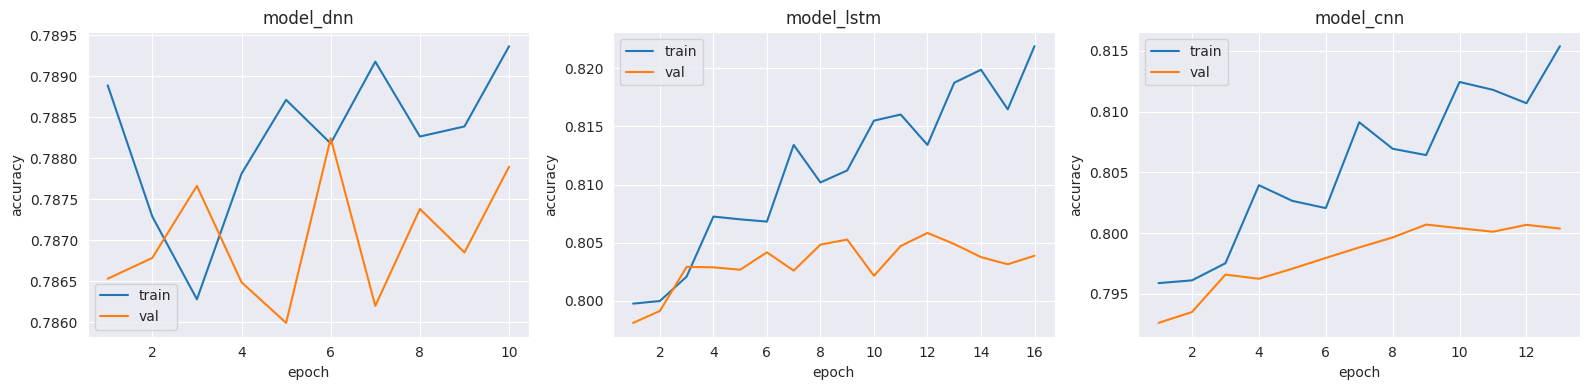

In [58]:
num_models=3
fig, ax = plt.subplots(1,num_models,figsize=(16,4))
model_names=['model_dnn','model_lstm','model_cnn']

for model_val in range(num_models):
  hist_df=list_hist_df[model_val]
  hist_df['epoch']=np.arange(1,hist_df.shape[0]+1)
  ax[model_val].plot(hist_df['epoch'],hist_df['accuracy'],label='train')
  ax[model_val].plot(hist_df['epoch'],hist_df['val_accuracy'],label='val')
  ax[model_val].set_title(model_names[model_val])
  ax[model_val].set_xlabel('epoch')
  ax[model_val].set_ylabel('accuracy')
  ax[model_val].legend()

fig.tight_layout()

#5. Accuracy Assessement and evaluation of models

Let's now evaluate and compare the accuracy of the trained models. We will use the following steps:

- predict on the test data using the trainde model
- generate a confusion matrix
- generate evaluation metrics including precision and recall for the positve and negative classes

We can then compare the metrics between the different models. We will manually show the different steps and then use a function to generate evaluation metrics in a tabular format for model comparison.

Let's first start by showing how to make predictions with a the CNN based model. It is simple using the 'predict' method avaible from the keras model object. This produces scores for each class and sample.

In [59]:
y_score = model_cnn.predict(X_test)
print(type(y_score))
y_score.shape

10000/10000 [==============================] - 66s 7ms/step
<class 'numpy.ndarray'>


(320000, 2)

We can convert this to a data frame and label the sample by taking the maximum score from the class scores.

In [60]:
y_pred_test_df = pd.DataFrame(y_score)
y_pred_test_df['y_pred_test'] = y_pred_test_df.idxmax(axis = 1) #one to go across the column for each row

y_pred_test_df

,0,1,y_pred_test
0,0.169142,0.830858,1
1,0.138553,0.861447,1
2,0.042368,0.957632,1
3,0.038508,0.961492,1
4,0.114451,0.885549,1
...,...,...,...
319995,0.227438,0.772562,1
319996,0.341292,0.658707,1
319997,0.679165,0.320835,0
319998,0.987073,0.012927,0


Next, we leverage the functionality from sklearn to produce a confusion matrix and a classifcation report. The off diagonals are the samples incorrectly labeled.

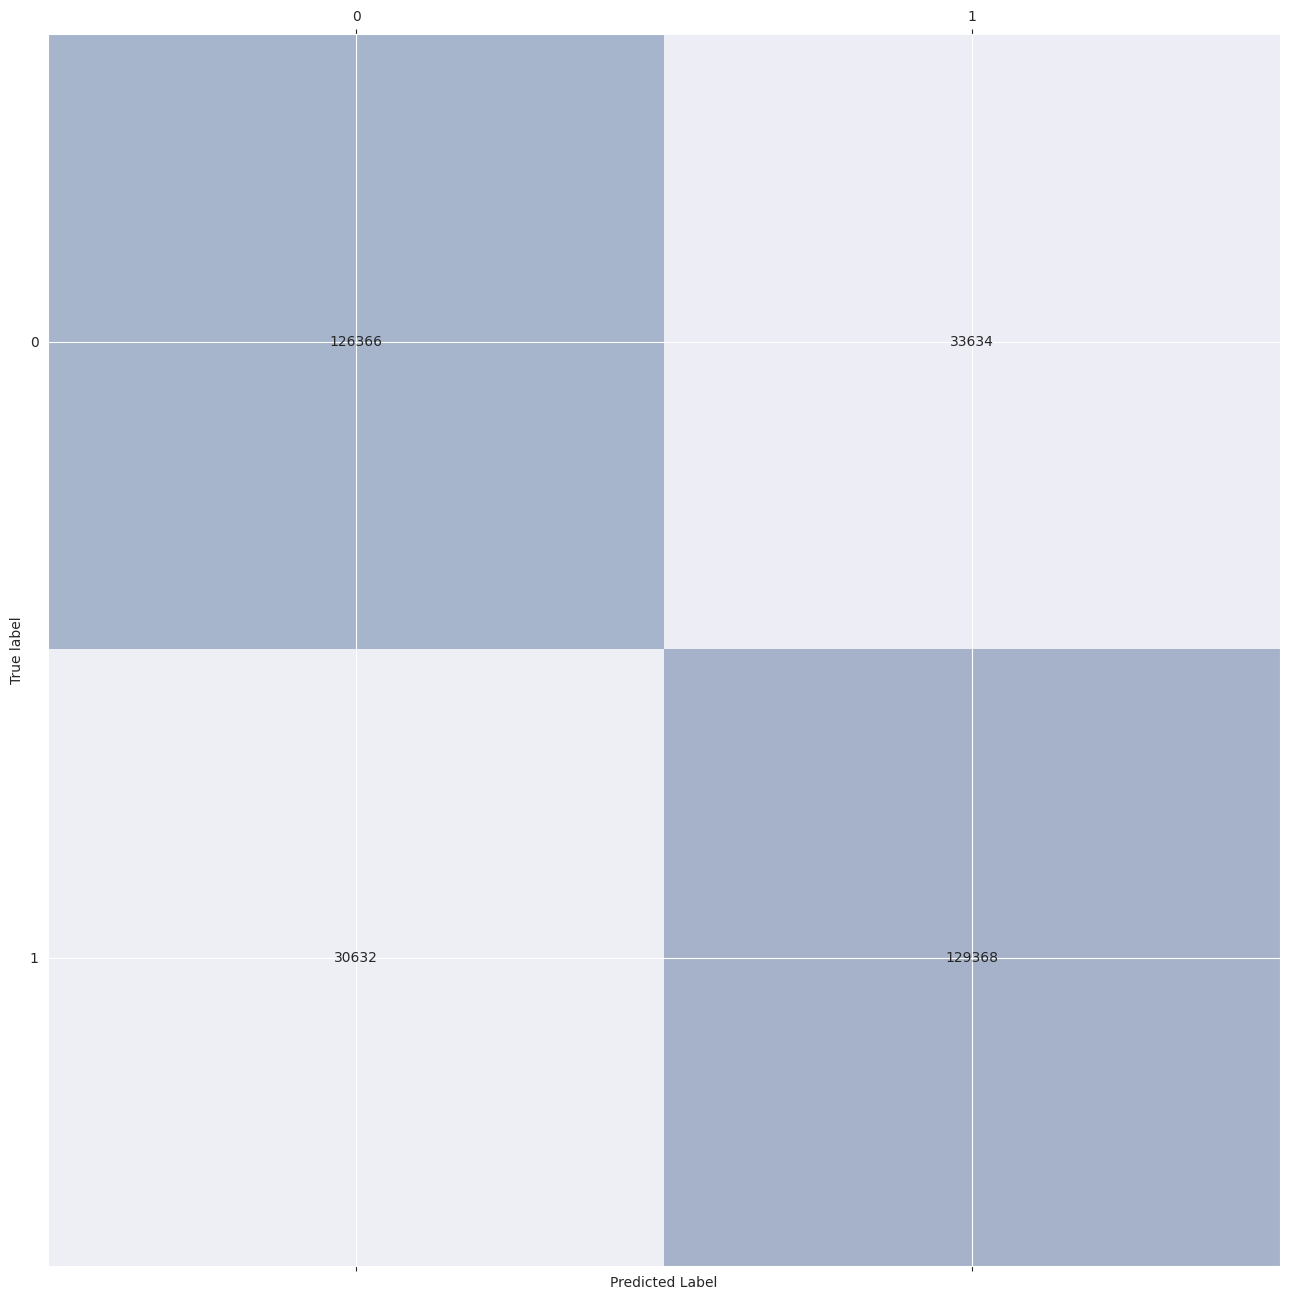

In [61]:
#from sklearn.metrics import classification_report
#from sklearn.metrics import confusion_matrix
y_pred_test = y_pred_test_df['y_pred_test']
report_dict=classification_report(y_test,
                                      y_pred_test,
                                      output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
confusion_matrix_val = confusion_matrix(y_test,y_pred_test)

fig, ax = plt.subplots(figsize=(16,16))
ax.matshow(confusion_matrix_val,cmap=plt.cm.Blues,alpha=0.3)
for i in range(confusion_matrix_val.shape[0]):
  for j in range(confusion_matrix_val.shape[1]):
    ax.text(x=j,y=i,
               s=confusion_matrix_val[i,j],
               va='center',
               ha='center')
    plt.xlabel('Predicted Label')
    plt.ylabel('True label')

The classification report provides a summary of the confusion matrix

In [62]:
report_df

,precision,recall,f1-score,support
0,0.804889,0.789787,0.797267,160000.000000
1,0.793659,0.808550,0.801035,160000.000000
accuracy,0.799169,0.799169,0.799169,0.799169
macro avg,0.799274,0.799169,0.799151,320000.000000
weighted avg,0.799274,0.799169,0.799151,320000.000000


In [63]:
list_report_df = []
#class_names=['negative','neutral','positive']
class_names=['negative','positive']

for model in list_models:
  report_df = generate_accuracy(model,y_test,X_test,class_names=class_names )
  list_report_df.append(report_df)
#list_report_df

from functools import reduce
report_df = reduce(lambda df1,df2: df1.merge(df2,"outer"),list_report_df)
report_df

10000/10000 [==============================] - 67s 7ms/step


,metric,negative,positive,accuracy,model_name,num_param
0,precision,0.794015,0.780306,0.786997,model_dnn,160154
1,recall,0.775062,0.798931,0.786997,model_dnn,160154
2,precision,0.798830,0.809042,0.803850,model_lstm,160818
3,recall,0.812250,0.795450,0.803850,model_lstm,160818
4,precision,0.804889,0.793659,0.799169,model_cnn,161330
5,recall,0.789787,0.808550,0.799169,model_cnn,161330


#6.Conclusions

In this exercise/blog/lab, we built three different deep learning models for NLP sentiment analysis. We use the sentiment140 dataset containing 1.8 million tweets. It is a balanced dataset with two labels: positive and negative.

We expermented with three types or architecture:

- a dense neural network (dnn): or fully connected layers stacked on top of each other.

- a ltsm based network: with recursive network using lstm layer and dense layers. This takes into account the sequence of tokens learning patterns.

- a cnn based network: with convolutional network using CONV1D layers. This takes into account the context of tokens with a window when learning patterns.

## Model comparison

We found that:
- precision is largely similar across models from 0.78 to 0.81 for positive cases and 0.80 to 0.81 fo
- recall is largely similar across models but with lowest values obtained using DNN.

The highest recall is achieved for positive cases using model cnn.
and the highest precision achiedved for negative cases using model_cnn. This may suggest we should use model_cnn but the hgiht precision for positive case is achieved by model_lstm (0.81 compared to 0.80 for model_cnn) while recall is also the highest for negative cases for model_lstm (0.81 compared to 0.79 for model_cnn). Since the dataset is balanced, we can look at accuracy which whould provide a global measure.  Using accuracy model_lstm comes up on top but marginally.

## Improvements and discussion

Results suggest we need to do more work. We only use about half the data for training. We could rerun the training using the entire training data and for a longer number of epoch setting the patience to a longer number of epoch. The training curves may become smoother and provide more insight. We can already see however that there might a be a risk of overfitting as the validation loss and accuracy appear to plateau while the training changes.


#7. References



In [ ]:
############################# END OF SCRIPT ###################################